In [1]:
from Mask_RCNN_Detect import Mask_RCNN_Detect

Using TensorFlow backend.


In [2]:
weights = 'weights/epoch55.h5'
mrcnn = Mask_RCNN_Detect(weights)

W0907 02:23:12.777825 4540335552 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 02:23:12.809077 4540335552 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 02:23:12.812055 4540335552 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 02:23:12.840054 4540335552 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2139: The name tf.nn.fused_batch_norm is deprecated. Please us

Loading weights from  weights/epoch55.h5


In [3]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [4]:
%matplotlib inline

In [5]:
files = os.listdir('default_images/'); files

['tmp.PNG', 'default_window.jpeg']

# Plotting Combined Masks

In [ ]:
init = np.zeros([256*2, 256*3, 3])

In [ ]:
for i in range(6):
    im = plt.imread('imgcache/18/62239/' + files[i])
    if i <= 2:
        init[0:256, i*256:(i+1)*256, :] = im
    else:
        i -= 3
        init[256:256*2, i*256:(i+1)*256, :] = im

In [ ]:
init.shape

In [ ]:
plt.imshow(init)

In [ ]:
init = (init * 256).astype(np.uint8)

In [ ]:
masks = mrcnn._detect_with_split(init); masks

In [ ]:
plt.imshow(masks)

In [ ]:
plt.imshow(masks) # 5

In [ ]:
plt.imshow(masks) # 15

In [ ]:
plt.imshow(masks) # 30

In [ ]:
plt.imshow(masks) # 55

# Extracting only smaller masks

In [ ]:
def plot_mask(masks, labels):
    if masks is None: # just an empty plot
        plt.imshow(np.zeros([512,512,3]).astype(np.uint8))
        return
    net_image = np.zeros([masks.shape[0],masks.shape[1],3])
    assert masks.shape[-1] == len(labels)
    for i in range(masks.shape[2]):
        m = masks[:,:,i].astype(np.uint8)[:,:,None]
        mask = np.stack([m,m,m], axis=2).reshape((m.shape[0], m.shape[1], 3))
        if labels[i] == 'building':
            mask = mask * np.array([25,160,90]) # yellow for corn
        net_image += mask
    plt.imshow(net_image.astype(np.uint8))

In [ ]:
im = Image.fromarray(im)
im = im.resize((320,320), Image.ANTIALIAS)
out = mrcnn.model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])

In [ ]:
def small_merge(masks): # merges only the small ones inside
    net_mask = np.zeros((masks.shape[0],masks.shape[1]))
    for i,layer in enumerate(range(masks.shape[2])):
        m = masks[:,:,layer] # gives an id
        shared = (m & (net_mask != 0))
        i += 1
        shared_count = np.count_nonzero(shared)
        if (shared_count > 100):
            new_id = i
            tmp = np.argwhere(shared)[0]
            collision_id = net_mask[tmp[0], tmp[1]]
            collision_id_mask = net_mask == collision_id
a
            new_count = np.count_nonzero(m)
            collision_count = np.count_nonzero(collision_id_mask)

#             if new_count > collision_count and new_count < 10000:
#                 net_mask[collision_id_mask] = 0
#                 net_mask += m * i
            if new_count < collision_count:
                net_mask[collision_id_mask] = 0
                net_mask += m * i
        else:
            net_mask += m * i
    plt.imshow(net_mask.astype(np.uint8))
    return net_mask

In [ ]:
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # it works!!a

In [ ]:
res = small_merge(out[0]['masks'])

In [ ]:
plt.imshow(res != 0)

### Result

In [ ]:
im = (plt.imread('imgcache/18/62239/94167.png') * 256).astype(np.uint8)
plt.imshow(im)

In [ ]:
res = mrcnn.detect_building(im)

In [ ]:
plt.imshow(res)

# Rectanglify

In [6]:
import cv2

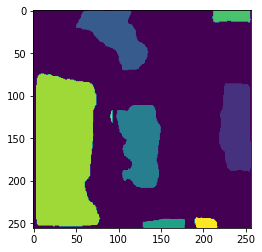

In [7]:
im = plt.imread('runtime/masks/mask_1.png')
plt.imshow(im)

In [ ]:
(im != [84,1,68]).shape

In [ ]:
plt.imshow((im != [84,1,68]) * 256)

In [ ]:
# im_flat = (im != [84,1,68]).all(axis=2)

In [ ]:
# im_flat = (im != [84,1,68]).all(axis=2)
im_one = (im == 109).any(axis=2)

In [ ]:
plt.imshow(im_one)

In [ ]:
from detectors.algorithms import Polygonify
def get_mask_corners(im):
    dst = cv2.cornerHarris(np.float32(im),2,3,0.04)
    idxs = np.argwhere(dst != 0)
    guides = np.median(idxs, axis=0)
    
    distr = np.sum((idxs - guides)**2,axis=1)
    # helps rule out far points
    lookup = distr <= 1.5 * np.median(distr)
    
    pg = Polygonify(idxs[lookup])
    res = pg.find_polygon()
    return res

In [ ]:
res = get_mask_corners(im_one)

In [ ]:
img = np.zeros((256,256,3), np.uint8)
for x,y in zip(res[:,0], res[:,1]):
    cv2.circle(img,(int(y), int(x)),5,[255,255,255])
plt.imshow(img)

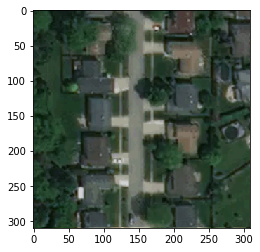

In [7]:
im = plt.imread('default_images/tmp.PNG')
plt.imshow(im)

In [ ]:
out = mrcnn.detect_building(im[:,:,:3], rectanglify=True, to_fill=True)

<class 'numpy.ndarray'> (310, 309, 3)
detecting single


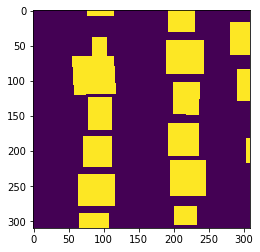

In [11]:
plt.imshow(out)